In [44]:
# パッケージ
%matplotlib inline
import numpy as np
import cv2 as cv # opencv
import matplotlib
import matplotlib.pyplot as plt # matplotlibの描画系
from matplotlib import cm
from collections import OrderedDict
import os
import math
import re
import glob


In [45]:
def split(string):
    re_list = re.split('[ X#@,()\t\n]',string)
    while '' in re_list:
        re_list.remove('')
    return re_list
    
def readQ(filename):
    Q = {'BLOCK':{}}
    with open(filename, 'r') as file:
        while True:
            str_line = file.readline()
            if not str_line:
                break
            result = split(str_line)
            if result == []:
                continue
            if result[0] == 'SIZE':
                Q['w'] = int(result[1])
                Q['h'] = int(result[2])
            elif result[0] == 'BLOCK_NUM':
                Q['n'] = int(result[1])
            elif result[0] == 'BLOCK':
                index = int(result[1])
                w = int(result[2])
                h = int(result[3])
                bs = Q['BLOCK']
                cells = {}
                bs[index] = {'index':index,'w':w,'h':h,'cells':cells}
                for i in range(h):
                    subline = file.readline()
                    subr = split(subline)
                    for j in range(w):
                        if subr[j] != '0':
                            cells[(j,i)] = subr[j]
    return Q
def readA(filename):
    A = {'BLOCK':{}}
    with open(filename, 'r') as file:
        i = 0
        while True:
            str_line = file.readline()
            if not str_line:
                break
            result = split(str_line)
            if result == []:
                continue
            if result[0] == 'SIZE':
                A['w'] = int(result[1])
                A['h'] = int(result[2])
                A['map'] = np.zeros((A['h'],A['w']), dtype=int)
            elif result[0] == 'BLOCK':
                index = int(result[1])
                x = int(result[2])
                y = int(result[3])
                bs = A['BLOCK']
                cells = {}
                bs[index] = {'index':index,'x':x,'y':y}
            else:
                for j in range(A['w']):
                    A['map'][i,j] = int(result[j])
                i += 1       
    return A

def index2color(index, mode='cell'):
    if mode == 'cell':
        if index == -1:
            R,G,B,Alpha = 1,1,1,1
        else:
            R,G,B,Alpha = cm.tab20((index*2)%20)
    else:
        R,G,B,Alpha = cm.tab20((index*2+1)%20)
    return np.array([R,G,B])

def QA2img(Q,A):
    w_grid = 5
    w_line = 25
    len_cell = 50
    margin = (len_cell + w_grid - w_line)//2
    white = [1,1,1]
    black = [0,0,0]
    red = [1,0,0]
    w_max, h_max = Q['w'],Q['h']
    w,h,n = A['w'],A['h'],Q['n']
    map_A = A['map']
    bs_q = Q['BLOCK']
    bs_a = A['BLOCK']
    img = np.zeros((h_max*len_cell+w_grid,w_max*len_cell+w_grid,3))
    img[:,:] = white
    img[[i for i in range(h_max*len_cell+w_grid) if (i%len_cell)<w_grid],:] = black
    img[:,[j for j in range(w_max*len_cell+w_grid) if (j%len_cell)<w_grid]] = black
    img[0:h*len_cell,0:w_grid] = red
    img[0:h*len_cell,w*len_cell:w*len_cell+w_grid] = red
    img[0:w_grid,0:w*len_cell] = red
    img[h*len_cell:h*len_cell+w_grid,0:w*len_cell+w_grid] = red

    for index in range(1, n+1):
        x, y = bs_a[index]['x'], bs_a[index]['y']
        cells = bs_q[index]['cells']
        for dx,dy in cells.keys():
            X = (x+dx)*len_cell
            Y = (y+dy)*len_cell
            img[Y+w_grid:Y+len_cell,X+w_grid:X+len_cell] = index2color(index-1, 'cell')
            
    for i in range(h):
        for j in range(w):
            index_line = map_A[i][j]
            if index_line == 0:
                continue
            X = j*len_cell
            Y = i*len_cell
            Xp = X+len_cell
            Yp = Y+len_cell
            img[Y+margin:Y+margin+w_line,X+margin:X+margin+w_line] = index2color(index_line, 'line')
            if j+1<w and map_A[i][j+1] == index_line:
                img[Y+margin:Y+margin+w_line,X+margin+w_line:X+margin+len_cell] = index2color(index_line, 'line')
                    
            if i+1<h and map_A[i+1][j] == index_line:
                img[Y+margin+w_line:Y+margin+len_cell,X+margin:X+margin+w_line] = index2color(index_line, 'line')
                            
            cv.putText(img, f'{index_line}', (X+margin,Y+margin+w_line-3), cv.FONT_HERSHEY_PLAIN, 1.5, (.1,.1,.1), 2)
                    
    return img
def show(index):
    paths = sorted(glob.glob(f"../Q*.txt"))
    Q = readQ(paths[index])
    A = readA(f'../A{paths[index][4:7]}.txt')
    print(f'A{paths[index][4:7]}.txt')
    img = QA2img(Q,A)
    print(f'問題サイズ{Q["w"]}×{Q["h"]},解答サイズ{A["w"]}×{A["h"]}')
    print(f'矩形領域の割合{(A["w"]*A["h"])/(Q["w"]*Q["h"])}')
    img_uint8 = (img*255).astype(int)
    R = np.array(img_uint8[:,:,2])
    B = np.array(img_uint8[:,:,0])
    img_uint8[:,:,0] = R
    img_uint8[:,:,2] = B
    cv.imwrite(f'A{index+1:03}.png', img_uint8)
    plt.imshow(img)

In [46]:
Q = readQ('../adc2019problem/Q001_10X10_b8_l11.txt')

In [47]:
print(Q)

{'BLOCK': {1: {'index': 1, 'w': 1, 'h': 4, 'cells': {(0, 0): '1', (0, 1): '+', (0, 2): '8', (0, 3): '7'}}, 2: {'index': 2, 'w': 3, 'h': 2, 'cells': {(1, 0): '8', (0, 1): '7', (1, 1): '6', (2, 1): '+'}}, 3: {'index': 3, 'w': 2, 'h': 3, 'cells': {(0, 0): '10', (0, 1): '+', (0, 2): '3', (1, 2): '9'}}, 4: {'index': 4, 'w': 2, 'h': 2, 'cells': {(0, 0): '1', (1, 0): '2', (0, 1): '4', (1, 1): '+'}}, 5: {'index': 5, 'w': 3, 'h': 2, 'cells': {(0, 0): '11', (1, 0): '+', (2, 0): '+', (2, 1): '3'}}, 6: {'index': 6, 'w': 3, 'h': 2, 'cells': {(1, 0): '+', (2, 0): '2', (0, 1): '5', (1, 1): '11'}}, 7: {'index': 7, 'w': 3, 'h': 2, 'cells': {(1, 0): '10', (2, 0): '6', (0, 1): '9', (1, 1): '5'}}, 8: {'index': 8, 'w': 3, 'h': 2, 'cells': {(0, 0): '+', (1, 0): '+', (1, 1): '+', (2, 1): '4'}}}, 'w': 10, 'h': 10, 'n': 8}


In [58]:
def add(e, _dict):
    if e not in _dict.keys():
        _dict[e] = len(_dict) + 1
def print_cnf(nodes, cnfs):
    s = []
    s.append(f'p cnf {len(nodes)} {len(cnfs)}')
    print(''.join(s))
    for cnf in cnfs:
        s_sub = ''
        for e in cnf:
            s_sub += f'{"" if cnf[e] == "1" else "-"}{nodes[e]} '
        s_sub += '0'
        print(s_sub)
        #s.append(s_sub)
    #print(''.join(s))
def read_satA(filename):
    with open(filename, 'r') as file:
        str_line = file.readline()
        ss = str_line.split()
    print(ss)

In [55]:
nodes = {}
cnfs = []
for b in Q['BLOCK'].keys():
    for i in range(Q['h']):
        for j in range(Q['w']):
            nodes[f'b{b}_{j}_{i}'] = len(nodes) + 1
for l in range(Q['n']):
    for i in range(Q['h']):
        for j in range(Q['w']):
            nodes[f'l{l}_{j}_{i}'] = len(nodes) + 1

In [56]:
# b one-hot
for b in Q['BLOCK'].keys():
    cnf = {}
    cnfs.append(cnf)
    for i in range(Q['h']):
        for j in range(Q['w']):
            cnf[f'b{b}_{j}_{i}'] = '1'
    for i in range(Q['h']):
        for j in range(Q['w']):
            for i2 in range(i, Q['h']):
                for j2 in range(Q['w']):
                    if i < i2 or j < j2:
                        cnf = {}
                        cnfs.append(cnf)
                        cnf[f'b{b}_{j}_{i}'] = '-1'
                        cnf[f'b{b}_{j2}_{i2}'] = '-1'

# line 0 or 1
for i in range(Q['h']):
    for j in range(Q['w']):
        for l in range(Q['n']-1):
            for l2 in range(l+1, Q['n']):
                cnf = {}
                cnfs.append(cnf)
                cnf[f'l{l}_{j}_{i}'] = '-1'
                cnf[f'l{l2}_{j}_{i}'] = '-1'


# 

In [57]:
print_cnf(nodes, cnfs)

p cnf 1600 39608
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 0
-1 -2 0
-1 -3 0
-1 -4 0
-1 -5 0
-1 -6 0
-1 -7 0
-1 -8 0
-1 -9 0
-1 -10 0
-1 -11 0
-1 -12 0
-1 -13 0
-1 -14 0
-1 -15 0
-1 -16 0
-1 -17 0
-1 -18 0
-1 -19 0
-1 -20 0
-1 -21 0
-1 -22 0
-1 -23 0
-1 -24 0
-1 -25 0
-1 -26 0
-1 -27 0
-1 -28 0
-1 -29 0
-1 -30 0
-1 -31 0
-1 -32 0
-1 -33 0
-1 -34 0
-1 -35 0
-1 -36 0
-1 -37 0
-1 -38 0
-1 -39 0
-1 -40 0
-1 -41 0
-1 -42 0
-1 -43 0
-1 -44 0
-1 -45 0
-1 -46 0
-1 -47 0
-1 -48 0
-1 -49 0
-1 -50 0
-1 -51 0
-1 -52 0
-1 -53 0
-1 -54 0
-1 -55 0
-1 -56 0
-1 -57 0
-1 -58 0
-1 -59 0
-1 -60 0
-1 -61 0
-1 -62 0
-1 -63 0
-1 -64 0
-1 -65 0
-1 -66 0
-1 -67 0
-1 -68 0
-1 -69 0
-1 -70 0
-1 -71 0
-1 -72 0
-1 -73 0
-1 -74 0
-1 -75 0
-1 -76 0
-1 -77 0
-1 -78 0
-1 -

A014.txt
問題サイズ10×10,解答サイズ10×6
矩形領域の割合0.6


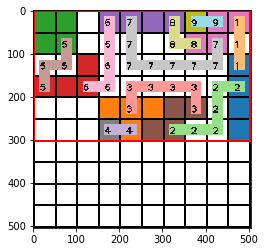

In [15]:
show(13)

A015.txt
問題サイズ10×10,解答サイズ9×6
矩形領域の割合0.54


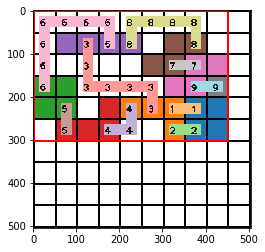

In [11]:
show(14)